In [2]:
import numpy as np
import pandas as pd

import argparse
import os

from psd_utils import lnprob, grab_data, model

from scipy.optimize import minimize, OptimizeResult

import matplotlib.pyplot as plt
from IPython.display import clear_output

class FitDebug:
    def __init__(self, freq, powers):
        self.freq = freq
        self.powers = powers

        self.losses = []
        self.n_iter = 0
    
    def update(self, int_res: OptimizeResult):
        self.losses.append(-lnprob(int_res, self.freq, self.powers))
        self.n_iter += 1

        if self.n_iter % 1 != 0: return

        clear_output(wait=True)

        fig, (model_ax, loss_ax) = plt.subplots(1, 2, figsize=(10,5))

        model_ax.plot(self.freq, self.powers, color="gray")
        step_vec = int_res.copy()
        step_vec[[1, 2, 3, 5]] = 10**(step_vec[[1, 2, 3, 5]])
        model_ax.plot(self.freq, model(self.freq, step_vec))
        model_ax.set_xscale("log")
        model_ax.set_yscale("log")

        loss_ax.plot(np.arange(self.n_iter), self.losses)
        loss_ax.relim()

        plt.show()
    
    def __call__(self, *args, **kwargs):
        return self.update(*args, **kwargs)

def fit_star(kic_id: str, star_row: pd.Series):
    freq, powers = grab_data(kic_id)

    W0 = np.median(powers[-40:])

    x0 = np.array(list(star_row[["nu_max", "H", "P", "tau", "alpha"]]) + [W0])
    
    x0_logged = x0.copy()
    x0_logged[[1, 2, 3, 5]] = np.log10(x0[[1, 2, 3, 5]])

    debug_listener = FitDebug(freq, powers)
    
    min_res: OptimizeResult = minimize(lambda t: -lnprob(t, freq, powers)/len(freq), x0_logged, callback=debug_listener)

    print(min_res)

def fit_stars(data_table: pd.DataFrame):
    for (kic_id, row) in data_table.iterrows():
        fit_star(kic_id, row) # type: ignore

def parse_args() -> pd.DataFrame:
    argparser = argparse.ArgumentParser()
    
    env_default = os.environ.get("RED_GIANT_DATA_PATH")
    argparser.add_argument(
        "--data-path",
        type=str,
        default=env_default,
        help="Path to data (defaults to $RED_GIANT_DATA_PATH)"
    )

    argparser.add_argument(
        "--start-id",
        type=int,
        default=0,
        help="First row to process."
    )

    argparser.add_argument(
        "--end-id",
        type=int,
        default=None,
        help="Last row (exclusive) to process"
    )

    args = argparser.parse_args()

    if args.data_path is None:
        argparser.error("Need either the --data-path flag or "
                        "$RED_GIANT_DATA_PATH environmental variable to be set")
    
    try:
        full_df = pd.read_csv(args.data_path, index_col="KIC")
    except Exception as e:
        argparser.error(f"Could not read {args.data_path}!\n{e}")

    column_difference = {"nu_max", "H", "P", "tau", "alpha"}.difference(full_df.columns)
    if column_difference:
        argparser.error(f"{args.data_path} does not have required columns {column_difference}")

    if args.start_id < 0:
        argparser.error(f"--start-id must be within bounds of data ([0, {len(full_df)}))")

    if args.end_id is None:
        args.end_id = len(full_df)

    if args.end_id > len(full_df) or args.end_id < args.start_id:
        argparser.error(f"--end-id must be within bounds of data ([0, {len(full_df)}])")

    return full_df.iloc[args.start_id:args.end_id]

In [3]:
data = pd.read_csv(os.environ.get("RED_GIANT_DATA_PATH", ""), index_col="KIC")

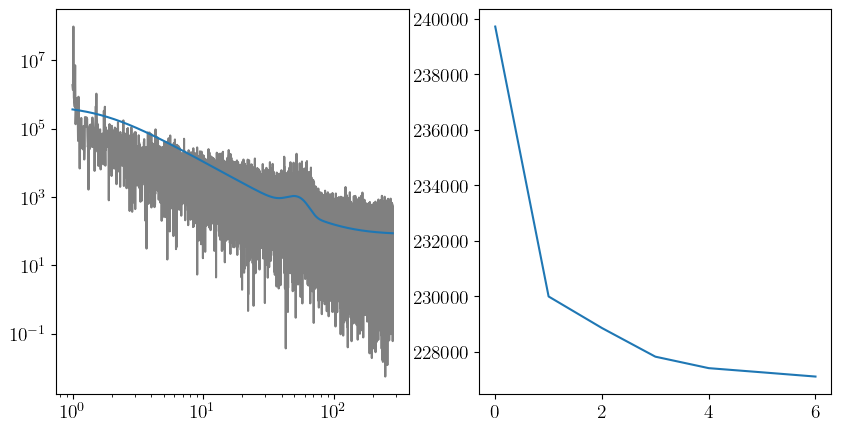

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 6.38162372194451
        x: [ 5.155e+01  2.817e+00  5.684e+00  4.975e+00  2.128e+00
             1.917e+00]
      nit: 7
      jac: [-1.280e-03 -1.112e-02  4.786e-02 -1.150e-01 -3.399e-02
             5.018e-02]
 hess_inv: [[ 1.012e+00 -1.070e-01 ... -1.668e-01 -2.871e-02]
            [-1.070e-01  2.210e+00 ...  1.484e+00  2.019e-01]
            ...
            [-1.668e-01  1.484e+00 ...  3.130e+00  4.428e-01]
            [-2.871e-02  2.019e-01 ...  4.428e-01  4.320e-01]]
     nfev: 93
     njev: 12


/home/andres/miniforge3/envs/astro/lib/python3.12/site-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


In [5]:
fit_stars(data.iloc[44:45])

In [6]:
data.iloc[44]

M                  1.580000
R                 10.190000
Teff            4789.000000
FeH               -0.570000
e_M                0.240000
e_R                0.540000
e_Teff            80.000000
e_FeH              0.150000
nu_max            51.540000
Delta_nu           5.188000
e_nu_max           2.440000
e_Delta_nu         0.048000
H               2712.556280
P               7917.116630
tau            11164.940660
alpha              2.420760
taue           20952.361260
sigma2        157419.168270
e_H              163.306965
e_P              325.183465
e_tau            360.634655
e_alpha            0.027170
e_taue           676.774535
e_sigma2        4551.882285
phase              2.000000
e_phase            0.000000
KepMag            11.571000
e_KepMag           0.000000
Name: 1572049, dtype: float64